In this workbook, we fit the processed raw data to narrow down the parameter space of the Neural Network

In [38]:
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from keras import backend as K

In [3]:
import pandas as pd
import numpy as np

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid', {'grid_color' : '0.9'})
sns.set_context('talk', font_scale=1.2)
sns.set_palette('gray')

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.utils import class_weight

In [5]:
from imblearn.over_sampling import SMOTE

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [6]:
mooc_df = pd.read_feather('../data/processed-mooc-data.feather')

mooc_clean_df = pd.get_dummies(mooc_df)

features = np.array(mooc_clean_df.drop('engaged', axis=1))
labels = np.array(mooc_clean_df['engaged'])

features_train, features_test, labels_train, labels_test = train_test_split(features, labels,
                                                                            test_size=0.2,
                                                                            random_state=20130810)

/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [103]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(labels_train),
                                                  labels_train)

In [110]:
K.clear_session()

In [111]:
def build(features_train,
          network_type=Sequential, 
          nb_initial_layer=64,
          dense_layer_lst=[64],
          nb_final_layer=1,
          learning_rate=1e-4):
    
    model = network_type()
    
    model.add(Dense(nb_initial_layer, input_shape=(features_train.shape[1], )))
    model.add(Activation('relu'))
    
    model.add(BatchNormalization())
    
    for nb_units in dense_layer_lst:
        model.add(Dense(nb_units))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
    model.add(Dense(nb_final_layer))
    model.add(Activation('sigmoid'))
    
    model.compile(optimizer=Adam(lr=learning_rate),
                  loss=binary_crossentropy,
                  metrics=[binary_accuracy])
    
    return model

In [112]:
out_file_path = '../data/best-keras-runs/' + 'mlp-model-{epoch:02d}-{val_binary_accuracy:.2f}_2018-10-04.hdf5'
model_history_path = '../data/best-keras-runs/' + '2018-10-04_model-history.feather'

In [113]:
model = build(features_train=features_train, 
              nb_initial_layer=32, 
              dense_layer_lst=[32, 32, 32], 
              learning_rate=1e-4)

In [114]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                960       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
__________

In [115]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=50,
                         validation_split=0.2,
                         class_weight=class_weights,
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6),
                                    ModelCheckpoint(out_file_path, 
                                                    monitor='val_binary_accuracy',
                                                    mode='max',
                                                    verbose=1, 
                                                    save_best_only=True, 
                                                    save_weights_only=False)])


Train on 202826 samples, validate on 50707 samples
Epoch 1/50
202826/202826 [==============================] - 8s 41us/step - loss: 0.6196 - binary_accuracy: 0.6674 - val_loss: 0.5948 - val_binary_accuracy: 0.6906

Epoch 00001: val_binary_accuracy improved from -inf to 0.69059, saving model to ../data/best-keras-runs/mlp-model-01-0.69_2018-10-04.hdf5
Epoch 2/50
202826/202826 [==============================] - 7s 36us/step - loss: 0.5856 - binary_accuracy: 0.6918 - val_loss: 0.5812 - val_binary_accuracy: 0.6926

Epoch 00002: val_binary_accuracy improved from 0.69059 to 0.69263, saving model to ../data/best-keras-runs/mlp-model-02-0.69_2018-10-04.hdf5
Epoch 3/50
202826/202826 [==============================] - 7s 36us/step - loss: 0.5748 - binary_accuracy: 0.6953 - val_loss: 0.5727 - val_binary_accuracy: 0.6951

Epoch 00003: val_binary_accuracy improved from 0.69263 to 0.69509, saving model to ../data/best-keras-runs/mlp-model-03-0.70_2018-10-04.hdf5
Epoch 4/50
202826/202826 [===========

202826/202826 [==============================] - 7s 37us/step - loss: 0.5525 - binary_accuracy: 0.7030 - val_loss: 0.5550 - val_binary_accuracy: 0.7027

Epoch 00032: val_binary_accuracy did not improve from 0.70272
Epoch 33/50
202826/202826 [==============================] - 8s 39us/step - loss: 0.5523 - binary_accuracy: 0.7035 - val_loss: 0.5550 - val_binary_accuracy: 0.7022

Epoch 00033: val_binary_accuracy did not improve from 0.70272
Epoch 34/50
202826/202826 [==============================] - 8s 39us/step - loss: 0.5525 - binary_accuracy: 0.7034 - val_loss: 0.5551 - val_binary_accuracy: 0.7022

Epoch 00034: val_binary_accuracy did not improve from 0.70272
Epoch 35/50
202826/202826 [==============================] - 8s 37us/step - loss: 0.5521 - binary_accuracy: 0.7030 - val_loss: 0.5550 - val_binary_accuracy: 0.7027

Epoch 00035: val_binary_accuracy did not improve from 0.70272
Epoch 36/50
202826/202826 [==============================] - 7s 36us/step - loss: 0.5524 - binary_accura

In [116]:
training_history = pd.DataFrame({"val_loss" : model_output.history["val_loss"],
                                 "val_binary_accuracy" : model_output.history["val_binary_accuracy"],
                                 "loss" : model_output.history["loss"],
                                 "accuracy" : model_output.history["binary_accuracy"]})

training_history.to_feather(model_history_path)

In [117]:
def plot_loss(fit_history):
    epochs = range(1, len(fit_history['accuracy'])+1)
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(epochs, fit_history['loss'], '--', label='Training loss')
    plt.plot(epochs, fit_history['val_loss'], '-', label='Validation loss')
    
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

In [118]:
def plot_accuracy(fit_history):
    
    epochs = range(1, len(fit_history['accuracy'])+1)
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(epochs, fit_history['accuracy'], '--', label='Training Accuracy')
    plt.plot(epochs, fit_history['val_binary_accuracy'], '-', label='Validation Accuracy')
    
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

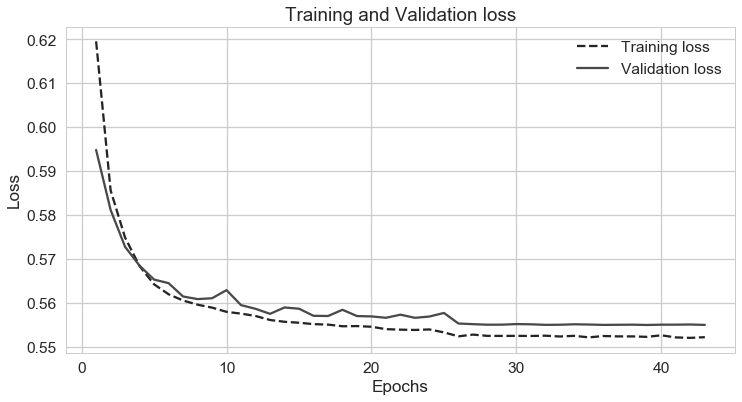

In [119]:
plot_loss(training_history)

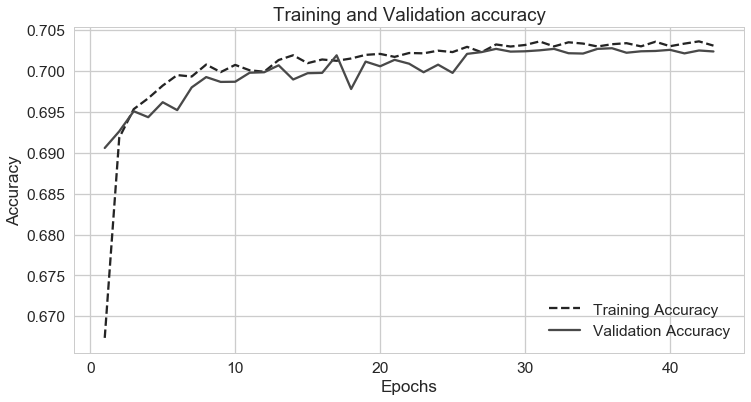

In [120]:
plot_accuracy(training_history)

In [126]:
def evaluate(best_model, features_test, labels_test):
    
    preds = best_model.predict_proba(features_test)
    
    fpr, tpr, _ = roc_curve(labels_test, preds)
    
    model_auc = auc(fpr, tpr)
    
    return pd.DataFrame(dict(false_positive_rate=fpr, true_positive_rate=tpr)), model_auc

In [127]:
best_model = load_model('../data/best-keras-runs/mlp-model-36-0.70_2018-10-04.hdf5')

In [128]:
nnet_roc_data, nnet_auc = evaluate(best_model, features_test, labels_test)

In [129]:
nnet_roc_data.to_feather('../data/nnet-roc.feather')